In [1]:
import numpy as np
import pandas as pd
import lxml.etree as etree
import sqlite3 as sql
from process import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, precision_score
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv('../data/prem_data_elo.csv', index_col = 'Unnamed: 0')
data.head()

,match_api_id,league_id,date,home_team_api_id_x,home_team_name,away_team_api_id_x,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,home_team_api_id_y,away_team_api_id_y,home_elo,away_elo
0,489044,1729,2008-08-16 00:00:00,8472,Sunderland,8650,Liverpool,0,2,2.0,...,0.0,0.0,0.0,0.0,0.0,L,8472,8650,1600.0,1600.0
1,489045,1729,2008-08-16 00:00:00,8654,West Ham United,8528,Wigan Athletic,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,L,8654,8528,1600.0,1600.0
2,489047,1729,2008-08-16 00:00:00,8668,Everton,8655,Blackburn Rovers,2,12,2.0,...,0.0,0.0,0.0,0.0,0.0,L,8668,8655,1600.0,1600.0
3,489048,1729,2008-08-16 00:00:00,8549,Middlesbrough,8586,Tottenham Hotspur,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,L,8549,8586,1600.0,1600.0
4,489049,1729,2008-08-16 00:00:00,8559,Bolton Wanderers,10194,Stoke City,3,4,2.0,...,0.0,0.0,0.0,0.0,0.0,L,8559,10194,1600.0,1600.0


## Running Multinomial Logit on Nominal Classes w/ Elo Score

#### Need to fix the data imbalance of class predictions

In [19]:
np.random.seed(1)
X = data[data.columns[7:]].drop(
    ['result', 'home_team_api_id_y', 'away_team_api_id_y', 'away_team_goal', 'home_team_goal'],
axis = 1)
y = data['result']


size = np.min(np.unique(y, return_counts = True)[1])
X_s = StandardScaler().fit_transform(X)
W = np.random.choice(np.arange(y.shape[0])[y == 'W'], size = size)
D = np.random.choice(np.arange(y.shape[0])[y == 'D'], size = size)
L = np.random.choice(np.arange(y.shape[0])[y == 'L'], size = size)

new_idx = np.concatenate([W, D, L])
X_i = X_s[new_idx]
y_i = y[new_idx]

# Stratify takes 75% from each class, works if we fix imbalance in original data
X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size = 0.2, stratify = y_i)

In [20]:
pd.DataFrame(np.array(np.unique(y_i, return_counts = True)).T, columns = ['Label', 'n']).sort_values(by = 'n')

,Label,n
0,D,323
1,L,323
2,W,323


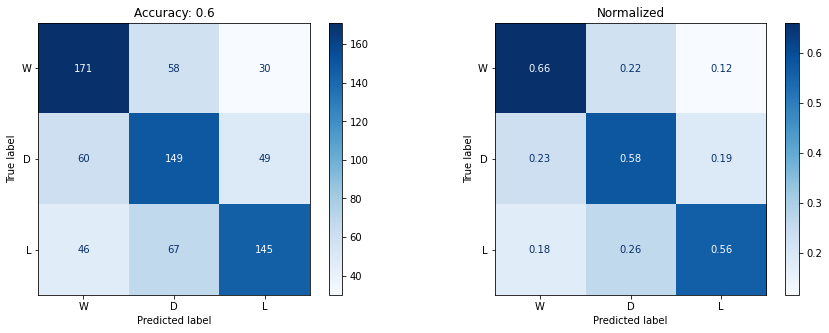

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.660232   0.617329  0.660232  0.638060      259
1      D  0.577519   0.543796  0.577519  0.560150      258
2      L  0.562016   0.647321  0.562016  0.601660      258
3  Total  0.600000   0.602834  0.600000  0.600006      775


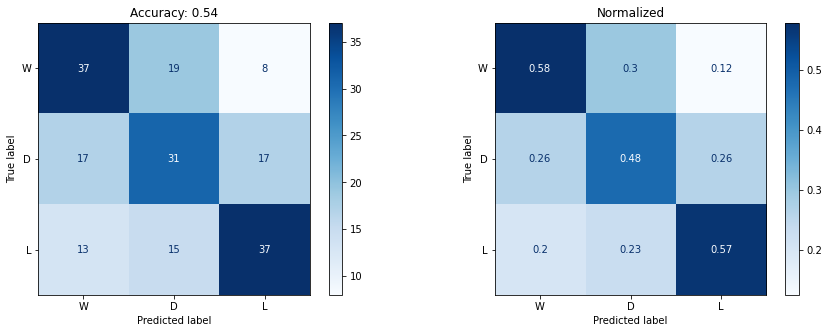

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.578125   0.552239  0.578125  0.564885       64
1      D  0.476923   0.476923  0.476923  0.476923       65
2      L  0.569231   0.596774  0.569231  0.582677       65
3  Total  0.541237   0.541926  0.541237  0.541375      194


In [21]:
params = {
    'multi_class' : 'multinomial'
}
clf = LogisticRegression(**params).fit(X_train, y_train)

print(metric_suite(clf, X_train, y_train))
print(metric_suite(clf, X_test, y_test))

## Running Multinomial Logit on Nominal Classes w/o Elo Score

In [9]:
X = data[data.columns[7:]].drop(
    ['away_team_goal', 'home_team_goal',
     'result', 'home_team_api_id_y',
     'away_team_api_id_y', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

X_s = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size = 0.2, stratify = y)

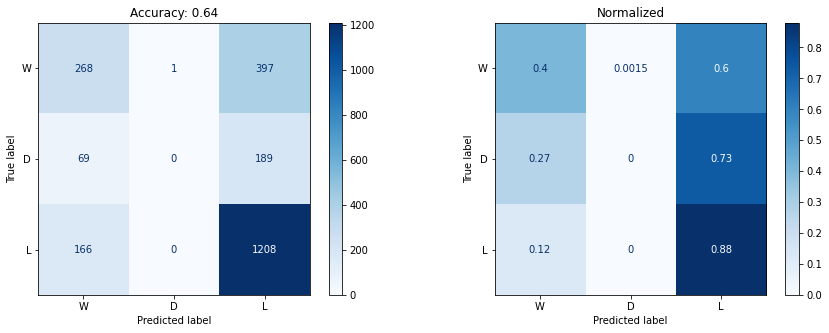

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.402402   0.532803  0.402402  0.458512      666
1      D  0.000000   0.000000  0.000000  0.000000      258
2      L  0.879185   0.673356  0.879185  0.762626     1374
3  Total  0.642298   0.557022  0.642298  0.588867     2298


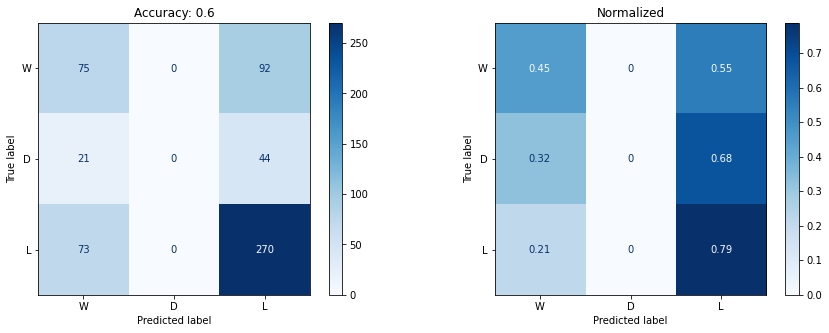

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.449102   0.443787  0.449102  0.446429      167
1      D  0.000000   0.000000  0.000000  0.000000       65
2      L  0.787172   0.665025  0.787172  0.720961      343
3  Total  0.600000   0.525593  0.600000  0.559727      575


In [11]:
params = {
    'multi_class' : 'multinomial'
}
clf = LogisticRegression(**params).fit(X_train, y_train)

print(metric_suite(clf, X_train, y_train))
print(metric_suite(clf, X_test, y_test))